In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
from ipynb.fs.full.Data_Processing import *
from ipynb.fs.full.evaluation import *
from braindecode.datasets.xy import create_from_X_y
import time
import numpy as np
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
from collections import namedtuple
import pickle
from sklearn.model_selection import KFold

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

In [3]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [4]:
def choose_cnn (model_depth, trainset, validset , n_classes , device, cuda , n_epochs):
    # Extract number of chans and time steps from dataset
    n_chans = trainset[0][0].shape[0]
    input_window_samples = trainset[0][0].shape[1]

    if model_depth == 'shallow':
        lr = 0.0625 * 0.01
        weight_decay = 0
        model =  ShallowFBCSPNet(n_chans, n_classes, input_window_samples=input_window_samples, final_conv_length="auto")
    else:
        lr = 1 * 0.01
        weight_decay = 0.5 * 0.001
        """
        For 30 samples, filter time_length = 1
        For 60 > samples, filter time length is left empty
        for 15 samples, filter_time length = 1, filter_length_2 = 1, filter_length_3 = 1
        """
        model =  Deep4Net(n_chans, n_classes, input_window_samples=input_window_samples,
                  final_conv_length="auto", pool_time_length=1, filter_time_length = 1,pool_time_stride=1)
    if cuda:
        model = model.cuda(0)

    batch_size = 32

    clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(validset),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,)
    return clf

In [5]:
def average(lst): 
    return sum(lst) / len(lst)

In [6]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [7]:
def is_slice_in_list(s,l):
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [8]:
def kfold_predict (X,y, model_type, n_epochs, model_depth):
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)

    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}

    total_predictions = []
    total_true = []
    num_classes = 0
    clf = None
    for train_index, test_index in kf.split(X):
        print("Train: ", train_index, "Validation: ", test_index)

        #Train/test split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))

        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        print(set(y_train))
        print(set(y_valid))

        size = len(X_train) + len(X_valid) #get dataset size

        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables 
        y_train, y_valid, le = categorise(y_train, y_valid)

        # Convert training and validation sets into a suitable format
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        trainset = create_from_X_y(X_train, y_train, drop_last_window=False)
        validset = create_from_X_y(X_valid, y_valid, drop_last_window=False)
        sys.stdout = save_stdout

        # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))

        # commence the training process
        time_start = time.time()
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        clf = choose_cnn (model_depth, trainset, validset , num_classes , device, cuda, n_epochs).fit(trainset, y=None, epochs=n_epochs)
        sys.stdout = save_stdout
        print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

        # make predictions
        y_pred = le.inverse_transform(clf.predict(X_valid))
        y_true = le.inverse_transform(y_valid)
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type)

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        

    for key in results: # finallly average out the results 
        results[key] = average(results[key])
    print("Accuracy".format(results['Accuracy']))
    return results, np.concatenate(total_predictions), np.concatenate(total_true), num_classes, size , clf

In [ ]:
def run_per_user(model_depth, window_size_samples, n_epochs):
    """
    Method for running the CNN per user
    """
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    

#     saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg.pickle".format(window_size_samples)
    all_tests = load_file(saved_file)
    users = all_tests.keys()
    model_type = 'clf'
    for user in users:
        print("Working on user {0}".format(user))
        torch.backends.cudnn.benchmark = True

        for label in labels:
            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).transpose(0,2,1).astype(np.float32) for x in dt['inputs']])     
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # train and make predictions
            r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs, model_depth)
            print(r['Accuracy'])

             # get results
            Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
            results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                                  r['F1 Score Macro'], r['F1 Score Micro']))

            # plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            saved_file = "results/CNN/confusion/k fold/{3}/per user/User_{0}_{1}_epochs_{2}.png".format(user,label,n_epochs,model_depth)
            plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

            #plot loss curve
            plot_loss_curve(clf)
            plt.savefig("results/CNN/loss curves/k fold/{3}/per user/User_{0}_{1}_epochs_{2}.png".format(user,label, n_epochs, model_depth))
            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/{2}/Valid_performance_window_size_{0}_{1}.csv".format(window_size_samples, n_epochs, model_depth), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

Working on user 1
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 84.60609459877014 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 82.66447305679321 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 85.21870040893555 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 83.45076894760132 seconds
Accuracy
0.3520151170619319
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.         0.38461538 0.61538462 0.         0.        ]
 [0.07488987 0.21585903 0.6123348  0.0660793  0.030837  ]
 [0.09271523 0.13245033 0.56953642 0.10596026 0.09933775]
 [0.24087591 0.10218978 0.37956204 0.13138686 0.1459854 ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide


Finished analysis on User 1_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 83.41546607017517 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 84.35466766357422 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 82.42492508888245 seconds
Accuracy
0.24715842778451017
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.         0.         1.         0.         0.        ]
 [0.07438017 0.3553719  0.23966942 0.33057851 0.        ]
 [0.04188482 0.11518325 0.28272251 0.39267016 0.16753927]
 [0.43925234 0.10280374 0.         0.45794393 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide


Finished analysis on User 1_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 53.41992712020874 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

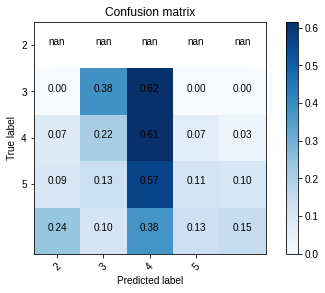

Error in callback <function flush_figures at 0x7f5898e5b710> (for post_execute):


KeyboardInterrupt: 

In [14]:
# run_per_user('shallow',120, 500)

In [ ]:
# # save model 
# saved_file = "models/attention_user_1_with_fi.pickle"
# with open(saved_file, 'wb') as handle:            
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
def run_cross_user(model_depth, window_size_samples):
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']


#     saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_30_window_annotated_EEG.pickle"
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg.pickle".format(window_size_samples)
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    n_epochs  = 200
    model_type = 'clf'
    user ='all'
    torch.backends.cudnn.benchmark = True


    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()


        # convert the inputs  into #samples, channels, #timepoints format
        X = np.array([all_tests_agg[user]['inputs'].transpose(0,2,1).astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs, model_depth)
        print(r['Accuracy'])

         # get results
        Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
        results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                              r['F1 Score Macro'], r['F1 Score Micro']))

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/confusion/k fold/{0}/cross user/Label_{1}_n_epochs_{2}.png".format(model_depth, label, n_epochs)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

        #plot loss curve
        plot_loss_curve(clf)
        plt.savefig("results/CNN/loss curves/k fold/{1}/cross user/Label_{0}_{2}.png".format(label, model_depth, n_epochs))
        print("Finished analysis on label {0}".format(label))
    print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/{1}/{1}CNN_Valid_performance_window_size_{0}_cross_user_n_epochs{2}.csv".format(window_size_samples , model_depth,n_epochs), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

#     model_path =  "/cs/home/ybk1/Dissertation/data/models/cross_user_30_window.pickle"
#     save_file(model_path,clf)

In [ ]:
run_cross_user('shallow', 120)

Working on label attention
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2367.8780605793 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2517.861288547516 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}
